In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Pneumonia FL/train/'
test_dir = '/content/drive/MyDrive/Pneumonia FL/test/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

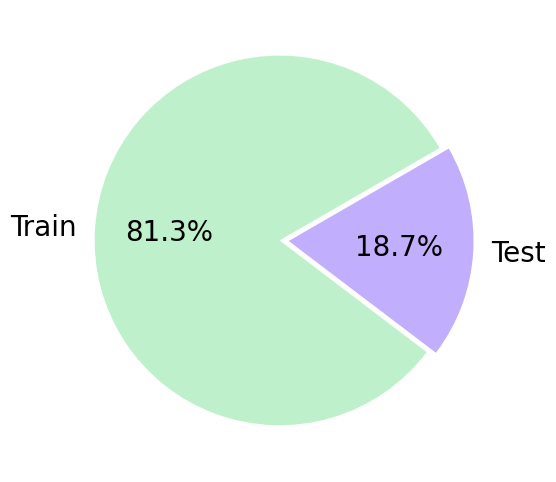

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#BEF0CB', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [5]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

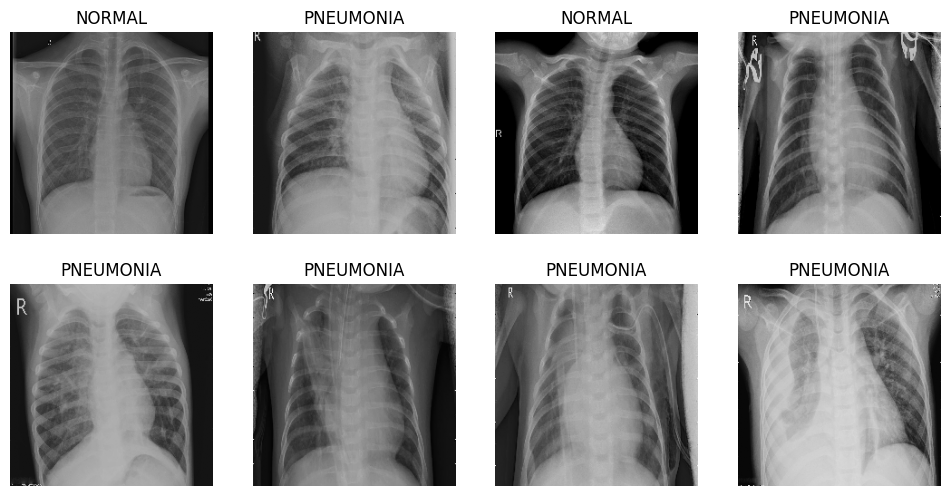

In [6]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [7]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [8]:
base_model = MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

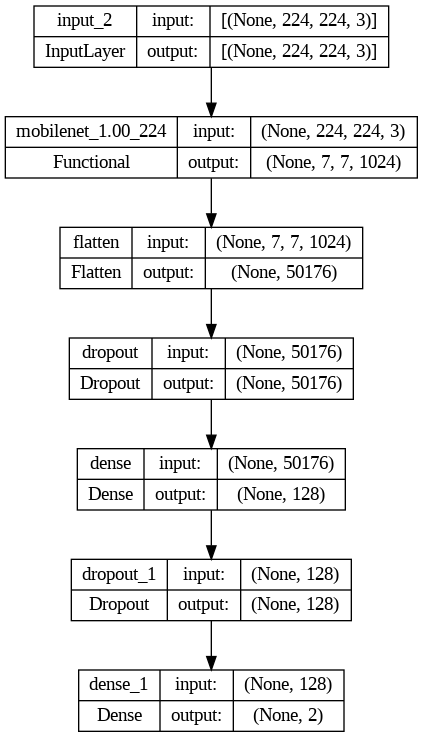

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [10]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 1557s 7s/step - loss: 0.2014 - sparse_categorical_accuracy: 0.9372
Epoch 2/10
234/234 [==============================] - 65s 271ms/step - loss: 0.0797 - sparse_categorical_accuracy: 0.9706
Epoch 3/10
234/234 [==============================] - 64s 272ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9850
Epoch 4/10
234/234 [==============================] - 64s 272ms/step - loss: 0.0288 - sparse_categorical_accuracy: 0.9893
Epoch 5/10
234/234 [==============================] - 63s 267ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9925
Epoch 6/10
234/234 [==============================] - 64s 271ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9942
Epoch 7/10
234/234 [==============================] - 64s 273ms/step - loss: 0.0106 - sparse_categorical_accuracy: 0.9966
Epoch 8/10
234/234 [==============================] - 64s 272ms/step - loss: 0.0102 - sparse_categorical_accuracy: 0.9961
Epoch 9/10
234/234 [=====

# Federated Learning Based transfer Learning enabled MobileNet Model

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

# Deploy the model
model.save('my_model.h5')

Epoch 1/5
58/58 [==============================] - 18s 270ms/step - loss: 0.0148 - sparse_categorical_accuracy: 0.9948
Epoch 2/5
58/58 [==============================] - 16s 268ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.9991
Epoch 3/5
58/58 [==============================] - 17s 288ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9965
Epoch 4/5
58/58 [==============================] - 16s 276ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9991
Epoch 5/5
58/58 [==============================] - 16s 272ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9930
Epoch 1/5
58/58 [==============================] - 18s 264ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9948
Epoch 2/5
58/58 [==============================] - 15s 268ms/step - loss: 0.0137 - sparse_categorical_accuracy: 0.9948
Epoch 3/5
58/58 [==============================] - 16s 268ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9991
Epoch 4/5
58/58 [==============================]

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  3%|▎         | 1/36 [00:12<07:14, 12.41s/it]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 2/36 [00:22<06:21, 11.22s/it]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 3/36 [00:33<05:56, 10.81s/it]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 4/36 [00:48<06:38, 12.46s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 5/36 [01:03<06:56, 13.43s/it]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 6/36 [01:14<06:16, 12.56s/it]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 7/36 [01:24<05:42, 11.82s/it]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 8/36 [01:35<05:21, 11.50s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 9/36 [01:46<05:06, 11.35s/it]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 10/36 [01:56<04:45, 10.99s/it]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 11/36 [02:08<04:41, 11.26s/it]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 12/36 [02:19<04:31, 11.30s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 13/36 [02:30<04:13, 11.04s/it]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 14/36 [02:40<03:56, 10.74s/it]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 15/36 [02:50<03:43, 10.64s/it]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 16/36 [03:01<03:32, 10.62s/it]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 17/36 [03:14<03:35, 11.36s/it]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 18/36 [03:24<03:20, 11.14s/it]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 19/36 [03:35<03:05, 10.92s/it]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 20/36 [03:46<02:55, 10.96s/it]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 21/36 [03:57<02:43, 10.91s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 22/36 [04:07<02:30, 10.73s/it]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 23/36 [04:17<02:18, 10.67s/it]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 24/36 [04:28<02:06, 10.58s/it]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 25/36 [04:38<01:56, 10.55s/it]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 26/36 [04:49<01:47, 10.72s/it]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 27/36 [05:00<01:35, 10.65s/it]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 28/36 [05:11<01:26, 10.76s/it]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 29/36 [05:21<01:13, 10.49s/it]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 30/36 [05:31<01:03, 10.54s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 31/36 [05:42<00:52, 10.49s/it]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 32/36 [05:52<00:41, 10.40s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 33/36 [06:03<00:31, 10.54s/it]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 34/36 [06:14<00:21, 10.57s/it]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 35/36 [06:25<00:10, 10.81s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 36/36 [06:35<00:00, 10.74s/it]

1/1 [==============================] - 1s 601ms/step


37it [06:43, 10.90s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.88      0.97      0.93       317
   PNEUMONIA       0.99      0.95      0.97       855

    accuracy                           0.96      1172
   macro avg       0.94      0.96      0.95      1172
weighted avg       0.96      0.96      0.96      1172



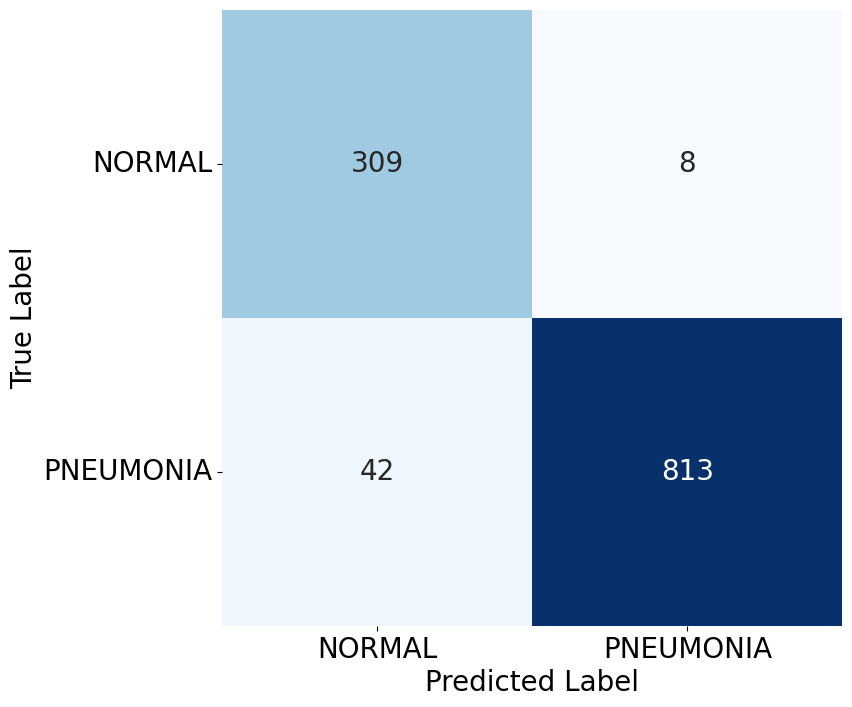

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()



# Improved Code of Transfer Learning Based MobileNet Model

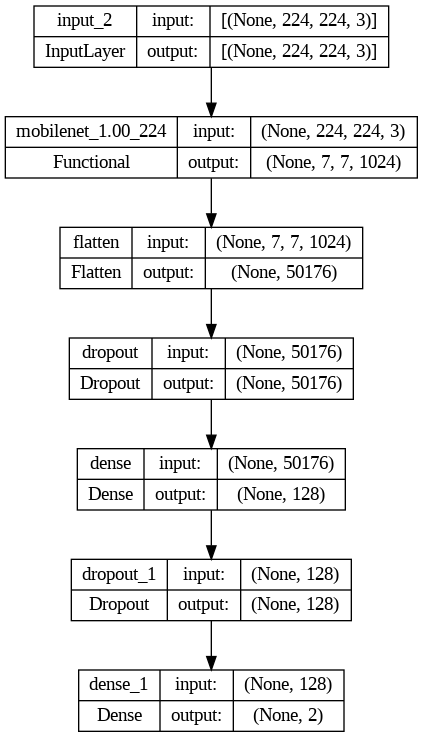

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [16]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
234/234 [==============================] - 92s 382ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9957
Epoch 2/10
234/234 [==============================] - 82s 353ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.9996
Epoch 3/10
234/234 [==============================] - 65s 276ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9949
Epoch 4/10
234/234 [==============================] - 65s 277ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9919
Epoch 5/10
234/234 [==============================] - 65s 277ms/step - loss: 0.0238 - sparse_categorical_accuracy: 0.9942
Epoch 6/10
234/234 [==============================] - 65s 277ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9942
Epoch 7/10
234/234 [==============================] - 73s 313ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9966
Epoch 8/10
234/234 [==============================] - 64s 274ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9981
Epoch 9/10
234/234 [====

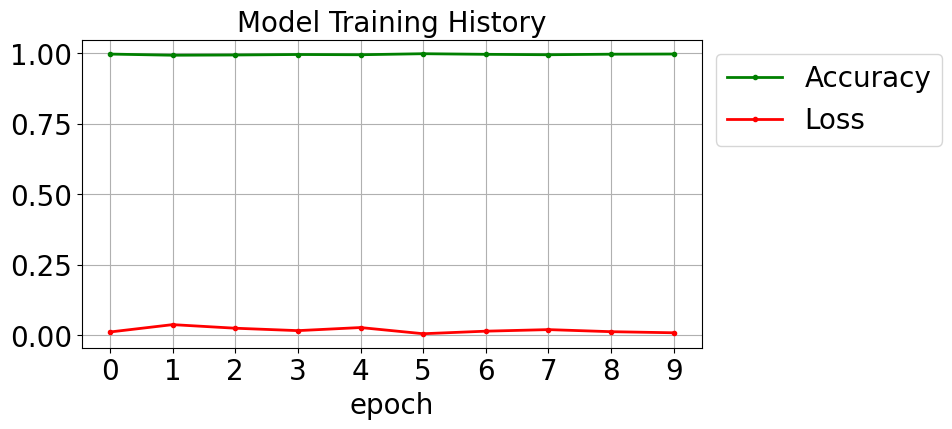

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

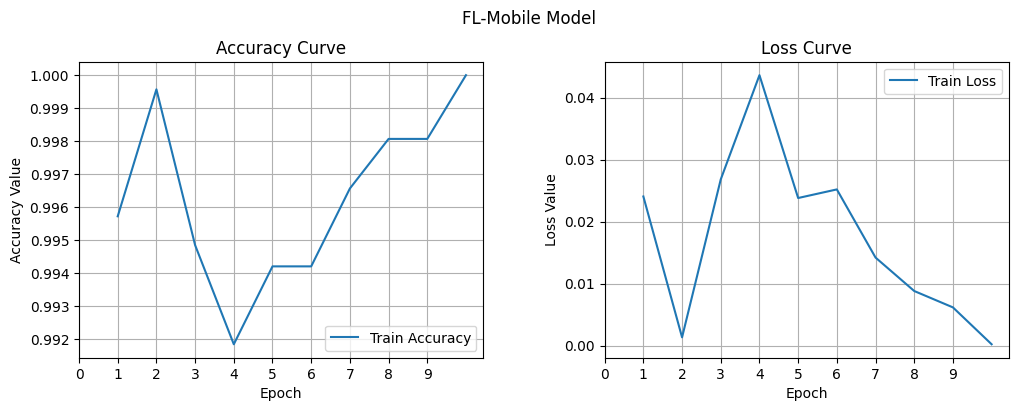

In [27]:
import matplotlib.pyplot as plt
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('FL-Mobile Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['sparse_categorical_accuracy'], label='Train Accuracy')
#ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks([x for x in range(epochs)])
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy Curve')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
#ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks([x for x in range(epochs)])
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss Curve')
l2 = ax2.legend(loc="best")
plt.savefig('curve1',dpi=400)

In [28]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/36 [00:00<?, ?it/s]

1/1 [==============================] - 0s 411ms/step


  3%|▎         | 1/36 [00:00<00:30,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 2/36 [00:01<00:22,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 3/36 [00:01<00:19,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 4/36 [00:02<00:17,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 5/36 [00:02<00:17,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 6/36 [00:03<00:15,  1.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 7/36 [00:03<00:14,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 8/36 [00:04<00:14,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 9/36 [00:04<00:13,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 10/36 [00:05<00:12,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 11/36 [00:05<00:12,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 12/36 [00:06<00:12,  1.91it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 13/36 [00:07<00:12,  1.85it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 14/36 [00:07<00:12,  1.70it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 15/36 [00:08<00:12,  1.62it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 16/36 [00:09<00:12,  1.64it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 17/36 [00:09<00:11,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 18/36 [00:10<00:10,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 19/36 [00:10<00:09,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 20/36 [00:11<00:09,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 21/36 [00:11<00:08,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 22/36 [00:12<00:07,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 23/36 [00:12<00:06,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 24/36 [00:13<00:06,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 25/36 [00:13<00:05,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 26/36 [00:14<00:05,  2.00it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 27/36 [00:14<00:04,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 28/36 [00:15<00:03,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 29/36 [00:15<00:03,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 30/36 [00:16<00:02,  2.00it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 31/36 [00:16<00:02,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 32/36 [00:17<00:01,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 33/36 [00:17<00:01,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 34/36 [00:18<00:00,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 35/36 [00:18<00:00,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 36/36 [00:19<00:00,  1.98it/s]

1/1 [==============================] - 0s 432ms/step


37it [00:19,  1.86it/s]


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      NORMAL       0.96      0.94      0.95       317
   PNEUMONIA       0.98      0.99      0.98       855

    accuracy                           0.97      1172
   macro avg       0.97      0.96      0.97      1172
weighted avg       0.97      0.97      0.97      1172



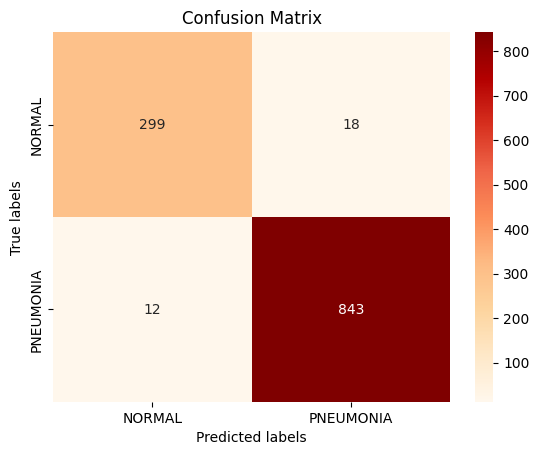

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, cmap="OrRd", fmt="d", annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap',dpi=400)

In [31]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 843.000000 TN: 299.000000 FP: 18.000000 FN: 12.000000


In [46]:
acc=(TP+TN)/float(TP+TN+FP+FN)
print(' acc: %.4f' % acc)
recall=TP/float(TP+FN)
print(' Recall: %.4f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.4f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.4f' % f1)

 acc: 0.9744
 Recall: 0.9860
 Precision: 0.9791
F1 Score: 0.9825
